In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ABTE
Попробуем, как RuBERT справляется с ABTE после а) файн-тьюнинга, б) дообучения только верхних слоёв через библиотеку [`adapterhub`](https://docs.adapterhub.ml/classes/models/bert.html). Основа взята [отсюда](https://github.com/nicolezattarin/BERT-Aspect-Based-Sentiment-Analysis/tree/main), мы:
- переписали `DataLoader` и предобработку под нужную нам структуру данных
- подправили линейный слой в модели для нашего количества классов
- сделали перевод из спанов в токены и обратно (NB: при обучении `CrossEntropyLoss` считается именно по токенам) -- `spans_to_tokens` и `predictor`

Формат, который ест модель - последовательность токенов + такой же длины последовательность их категорий (никакая или один из пяти аспектов), + последовательность тональностей (никакая или одна из четырёх возможных комбинаций).

--> [папка](https://drive.google.com/drive/folders/1qlgDgESbVsTUKmwEXEDl62LmSrhOpZf5?usp=sharing) с весами и логами

In [ ]:
!pip install adapters --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
from transformers import BertModel, BertTokenizer
from transformers import get_scheduler

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

import time
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer as twt
from adapters import AutoAdapterModel

tokenizer_path = 'cointegrated/rubert-tiny2'
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

In [ ]:
os.chdir('/content/drive/MyDrive/')
os.mkdir('nlp_project')
PATH = '/content/drive/MyDrive/nlp_project'
os.chdir(PATH)

In [ ]:
os.getcwd()

'/content/drive/MyDrive/nlp_project'

In [ ]:
#!pip install nltk pymorphy2 -q

In [ ]:
from collections import defaultdict
# переделываем данные в более удобный формат и кладём в датафрейм

def clean_data(review_path, aspect_path):
    with open(review_path, 'r', encoding='utf-8') as f:
        texts = f.read().split('\n')
    reviews = dict()
    for k in texts:
        try:
            text_n, text_b = k.split('\t')
            reviews[text_n] = text_b
        except:
            print(k)
    aspect_cats = {}
    indd = 0
    with open(aspect_path, 'r') as fg:
        for line in fg:
            line = line.rstrip('\r\n').split('\t')
            if line[0] not in aspect_cats:
                aspect_cats[line[0]] = {"starts":[], "ends":[], "cats":[], "pols":[]}
            aspect_cats[line[0]]["starts"].append(int(line[3]))
            aspect_cats[line[0]]["ends"].append(int(line[4]))
            aspect_cats[line[0]]["cats"].append(line[1])
            aspect_cats[line[0]]["pols"].append(line[5])
            aspect_cats[line[0]]["text"] = reviews[line[0]]
    return pd.DataFrame(aspect_cats).transpose()

In [ ]:
# номера текстов не нужны самой модели но потом понадобятся при предикте чтобы записать результаты
# поэтому они не идут в датасет модели а выделяются потом отдельно
def clean_idx(aspect_path):
  idx = []
  with open(aspect_path, 'r') as fg:
        for line in fg:
            line = line.rstrip('\r\n').split('\t')
            if line[0] not in idx:
                idx.append(line[0])
        return idx

In [ ]:
aspect_ids = clean_idx('train_aspects.txt')
dev_ids = clean_idx('dev_aspects.txt')

In [ ]:
aspects_raw = clean_data(os.path.join(PATH, 'train_reviews.txt'), os.path.join(PATH, 'train_aspects.txt'))
devs_raw = clean_data(os.path.join(PATH,'dev_reviews.txt'), os.path.join(PATH,'dev_aspects.txt'))

In [ ]:
#пройтись по текстам, по токенам в них и выбрать те токены, которые == или внутри промежутка выделенных аспектов. замаркировать эти токены
def spans_to_tokens(starts, ends, cats, pols, text):
    cats_to_ids = {'Food':1, 'Interior':2,'Price':3,'Service':4,'Whole':5}
    pols_to_ids = {'positive':1, 'negative':2, 'neutral':3, 'both':4}
    tokens = list(twt().span_tokenize(text))
    real_tokens = list(twt().tokenize(text))
    pairs = list(zip(starts, ends))
    token_cats = []
    token_pols = []
    for token in tokens:
        found = False
        for pair, cat, pol in zip(pairs, cats, pols):
            if token == pair or (token[0] >= pair[0] and token[1] <= pair[1]):
                token_cats.append(cats_to_ids[cat])
                token_pols.append(pols_to_ids[pol])
                found = True
                break
        if found == False:
            token_cats.append(0)
            token_pols.append(0)
    return real_tokens, tokens, token_cats, token_pols

In [ ]:
aspects_raw.iloc[:,:].values[0]

array([list([71, 198, 256, 267, 322, 349, 413, 476, 524, 564, 688, 739, 854, 880, 901, 933, 1019, 1038, 1053, 1067]),
       list([80, 208, 265, 285, 335, 370, 421, 485, 537, 568, 700, 748, 862, 886, 922, 940, 1027, 1043, 1064, 1076]),
       list(['Whole', 'Whole', 'Whole', 'Service', 'Service', 'Service', 'Whole', 'Whole', 'Food', 'Food', 'Service', 'Service', 'Interior', 'Interior', 'Interior', 'Interior', 'Whole', 'Food', 'Whole', 'Service']),
       list(['neutral', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'both', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']),
       'День 8-го марта прошёл, можно и итоги подвести. Решил написать отзыв о ресторане в котором отметили прекрасный весений праздник, прочитал отзывы edik077 и Rules77777и понял что либо мы были вразных ресторанах, либо у ребят что-то незаладилось. Но теперь о ресторане. Столик бронировали заранее и 

In [ ]:
devs_raw.to_csv('dev_inverse.tsv', sep='\t', index=False)
aspects_raw.to_csv('train_inverse.tsv', sep='\t', index=False)

In [ ]:
aspects_raw.head()

,starts,ends,cats,pols,text
3976,"[71, 198, 256, 267, 322, 349, 413, 476, 524, 5...","[80, 208, 265, 285, 335, 370, 421, 485, 537, 5...","[Whole, Whole, Whole, Service, Service, Servic...","[neutral, neutral, neutral, neutral, positive,...","День 8-го марта прошёл, можно и итоги подвести..."
30808,"[16, 43, 124, 147, 189, 254, 310, 337, 360, 37...","[25, 55, 145, 171, 200, 259, 318, 341, 370, 37...","[Whole, Interior, Whole, Service, Service, Foo...","[neutral, neutral, positive, positive, positiv...",Отмечали в этом ресторане день рождение на пер...
14031,"[48, 134, 183, 215, 265, 275, 296, 318, 469, 5...","[67, 144, 191, 228, 269, 287, 305, 336, 484, 5...","[Whole, Whole, Interior, Service, Food, Servic...","[neutral, positive, positive, positive, neutra...",Хочу поделиться своим впечатлением от посещени...
2495,"[42, 84, 107, 129, 292, 315, 341, 408, 429, 455]","[46, 91, 112, 138, 304, 324, 351, 413, 435, 465]","[Whole, Service, Food, Food, Service, Interior...","[neutral, positive, positive, positive, positi...",Добрый день! Были вчера с друзьями в этом кафе...
38835,"[51, 98, 108, 136, 179, 230, 343, 363, 371, 41...","[60, 106, 117, 143, 187, 238, 359, 369, 400, 4...","[Whole, Service, Service, Service, Service, Se...","[neutral, positive, positive, positive, positi...",Отметили с мужем годовщину свадьбы 6 ноября в ...


In [ ]:
#https://github.com/nicolezattarin/BERT-Aspect-Based-Sentiment-Analysis/blob/main/src/abte.py
#перелопаченный под наши нужды код отсюда

class ABTEDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __getitem__(self, idx):

        start, end, cat, pol, text = self.df.iloc[idx, :].values

        bert_tokens = []
        bert_tags = []
        try:
          tokens, _, tags, pols = spans_to_tokens(start, end, cat, pol, text)
        except:
          print(type(self.df.iloc[idx, :].values[0]))
        bert_pols = []
        for i in range(len(tokens)):
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            bert_tags += [tags[i]]*len(t)
            bert_pols += [pols[i]]*len(t)

        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        tags_tensor = torch.tensor(bert_tags)
        pols_tensor = torch.tensor(bert_pols)
        return bert_tokens, ids_tensor, tags_tensor, pols_tensor

    def __len__(self):
        return len(self.df)

In [ ]:
# https://docs.adapterhub.ml/quickstart.html

class ABTEBert(torch.nn.Module):
    def __init__(self, pretrain_model, adapter=True):
        super(ABTEBert, self).__init__()
        self.adapter = adapter
        if adapter:
            self.bert = AutoAdapterModel.from_pretrained(pretrain_model)
        else: self.bert = BertModel.from_pretrained(pretrain_model)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 6)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, tags_tensors, masks_tensors):
        bert_outputs= self.bert(input_ids=ids_tensors.to(), attention_mask=masks_tensors, return_dict=False)
        bert_outputs = bert_outputs[0]

        linear_outputs = self.linear(bert_outputs)
        if tags_tensors is not None:
            tags_tensors = tags_tensors.view(-1)
            linear_outputs = linear_outputs.view(-1,6)
            loss = self.loss_fn(linear_outputs, tags_tensors)
            return loss
        else:
            return linear_outputs

In [ ]:
class ABTEModel ():
    def __init__(self, tokenizer, adapter=True):
        self.model = ABTEBert('DeepPavlov/rubert-base-cased', adapter=adapter)
        self.tokenizer = tokenizer
        self.trained = False
        self.adapter = adapter

    def padding(self, samples):
        from torch.nn.utils.rnn import pad_sequence
        ids_tensors = [s[1] for s in samples]
        ids_tensors = pad_sequence(ids_tensors, batch_first=True)

        tags_tensors = [s[2] for s in samples]
        tags_tensors = pad_sequence(tags_tensors, batch_first=True)

        pols_tensors = [s[3] for s in samples]
        pols_tensors = pad_sequence(pols_tensors, batch_first=True)

        masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
        masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

        return ids_tensors, tags_tensors, pols_tensors, masks_tensors

    def load_model(self, model, path):
        model.load_state_dict(torch.load(path), strict=False)

    def save_model(self, model, name):
        torch.save(model.state_dict(), name)

    def train(self, data, epochs, device, batch_size=32, lr=1e-5, load_model=None, lr_schedule=True):

        #load model if lead_model is not None
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
                self.trained = True
            else:
                print("lead_model not found")

        # dataset and loader
        ds = ABTEDataset(data, self.tokenizer)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=self.padding)

        self.model = self.model.to(device)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        num_training_steps = epochs * len(loader)
        if lr_schedule: lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

        self.losses = []

        all_data = len(loader)-1
        for epoch in range(epochs):
            finish_data = 0
            current_times = []
            n_batches = int(len(data)/batch_size)

            if self.adapter:
                if lr_schedule: dir_name  = "model_ABTE_adapter_scheduler"
                else: dir_name = "model_ABTE_adapter"
            else:
                if lr_schedule: dir_name  = "model_ABTE_scheduler"
                else: dir_name = "model_ABTE"

            if not os.path.exists(dir_name):
                os.mkdir(dir_name)

            for nb in range((n_batches)):
                t0 = time.time()

                ids_tensors, tags_tensors, _, masks_tensors = next(iter(loader))
                ids_tensor = ids_tensors.to(device)
                tags_tensor = tags_tensors.to(device)
                masks_tensor = masks_tensors.to(device)
                loss = self.model(ids_tensors=ids_tensor, tags_tensors=tags_tensor, masks_tensors=masks_tensor)
                self.losses.append(loss.item())
                loss.backward()
                optimizer.step()
                if lr_schedule: lr_scheduler.step()
                optimizer.zero_grad()

                finish_data += 1
                current_time = round(time.time() - t0,3)
                current_times.append(current_time)
                print("epoch: {}\tbatch: {}/{}\tloss: {}\tbatch time: {}\ttotal time: {}"\
                    .format(epoch, finish_data, all_data, loss.item(), current_time, sum(current_times)))

                np.savetxt('{}/losses_lr{}_epochs{}_batch{}.txt'.format(dir_name, lr, epochs, batch_size), self.losses)


            self.trained = True
        self.save_model(self.model, '{}/model_lr{}_epochs{}_batch{}.pkl'.format(dir_name, lr, epoch, batch_size))

    def history (self):
        if self.trained:
            return self.losses
        else:
            raise Exception('Model not trained')

    def predict(self, sentence, load_model=None, device="cpu"):
         # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')
        self.model = self.model.to(device)
        word_pieces = list(twt().tokenize(sentence))
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        input_tensor = torch.tensor([ids]).to(device)

        #predict
        with torch.no_grad():
            outputs = self.model(input_tensor, None, None)
            _, predictions = torch.max(outputs, dim=2)

        predictions = predictions[0].tolist()
        return word_pieces, predictions, outputs

    def predict_batch(self, data, load_model=None, device="cpu"):

        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        predictions = []
        tags_real = []
        self.model = self.model.to(device)
        for i in tqdm(range(len(data))):
            sentence = data.iloc[i, 4]
            tokens, _, tags, _ = spans_to_tokens(*data.iloc[i, :].values)
            w, p, _ = self.predict(sentence, load_model=load_model, device=device)
            predictions.append(p)
            tags_real.append(tags[:len(p)])
        return predictions, tags_real

    def _accuracy (self, x,y):
        return np.mean(np.array(x) == np.array(y))

    def test(self, dataset, load_model=None, device="cpu"):
        from sklearn.metrics import classification_report
        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')
        self.model = self.model.to(device)
         # dataset and loader
        ds = ABTEDataset(dataset, self.tokenizer)
        loader = DataLoader(ds, batch_size=50, shuffle=True, collate_fn=self.padding)

        pred = []#padded list
        trueth = [] #padded list
        with torch.no_grad():
            for data in tqdm(loader):

                ids_tensors, tags_tensors, _, masks_tensors = data
                ids_tensors = ids_tensors.to(device)
                tags_tensors = tags_tensors.to(device)
                masks_tensors = masks_tensors.to(device)

                outputs = self.model(ids_tensors=ids_tensors, tags_tensors=None, masks_tensors=masks_tensors)

                _, p = torch.max(outputs, dim=2)

                pred += list([int(j) for i in p for j in i ])
                trueth += list([int(j) for i in tags_tensors for j in i ])

        acc = self._accuracy(pred, trueth)
        class_report = classification_report(trueth, pred, target_names=['none', 'Food','Interior', 'Price', 'Service', 'Whole'])
        return acc, class_report

    def accuracy(self, data, load_model=None, device='cpu'):
        a, p = self.test(data, load_model=load_model, device=device)
        return a

In [ ]:
def run_ABTE_test_train(adapter, lr_schedule):
    if adapter:
        if lr_schedule: dir_name  = "model_ABTE_adapter_scheduler"
        else: dir_name = "model_ABTE_adapter"
    else:
        if lr_schedule: dir_name  = "model_ABTE_scheduler"
        else: dir_name = "model_ABTE"

    #load
    data = clean_data('train_reviews.txt', 'train_aspects.txt')
    data_test = clean_data('dev_reviews.txt', 'dev_aspects.txt')

    # define parameters for model
    tokenizer_path = 'cointegrated/rubert-tiny2'
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # define model
    modelABTE = ABTEModel(tokenizer, adapter=adapter)

    # load model and predict
    model_path = dir_name+'/model_lr3.0000000000000004e-05_epochs9_batch8.pkl'
    test_accuracy, test_report = modelABTE.test(data_test, load_model=model_path, device=DEVICE)
    test_pred, test_targets = modelABTE.predict_batch(data_test, load_model=model_path, device=DEVICE)

    train_accuracy, train_report = modelABTE.test(data, load_model=model_path, device=DEVICE)
    train_pred, train_targets = modelABTE.predict_batch(data, load_model=model_path, device=DEVICE)

    #save results
    if not os.path.exists(dir_name+'/results'):
        os.makedirs(dir_name+'/results')

    #report
    with open(dir_name+'/results/test_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in test_report.split('\n'):
            f.write(r + '\n')

    with open(dir_name+'/results/train_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in train_report.split('\n'):
            f.write(r + '\n')

    #predictions
    #print(len(test_pred))
    #print(len(test_targets))
    data_test['Predicted'] = test_pred
    data_test['Actual'] = test_targets
    data_test.to_csv(dir_name+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    data['Predicted'] = train_pred
    data['Actual'] = train_targets
    data.to_csv(dir_name+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    #accuracy
    test_accuracy = np.array(test_accuracy)
    train_accuracy = np.array(train_accuracy)

    with open(dir_name+'/results/test_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(test_accuracy))
    with open(dir_name+'/results/train_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(train_accuracy))

### Обучаем:

In [ ]:
#сначала fine-tuning
batch = 8
lr = 3*1e-5
epochs = 10

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr_schedule = True
modelABTE = ABTEModel(tokenizer, False)
modelABTE.train(aspects_raw, batch_size=batch, lr=lr, epochs=epochs, device=DEVICE, lr_schedule=lr_schedule)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 0	batch: 1/35	loss: 2.211634635925293	batch time: 1.367	total time: 1.367
epoch: 0	batch: 2/35	loss: 0.5734702944755554	batch time: 0.215	total time: 1.582
epoch: 0	batch: 3/35	loss: 0.5403095483779907	batch time: 0.215	total time: 1.7970000000000002
epoch: 0	batch: 4/35	loss: 0.5292287468910217	batch time: 0.284	total time: 2.081
epoch: 0	batch: 5/35	loss: 0.4465903341770172	batch time: 0.253	total time: 2.334
epoch: 0	batch: 6/35	loss: 0.46677136421203613	batch time: 0.206	total time: 2.54
epoch: 0	batch: 7/35	loss: 0.4674968719482422	batch time: 0.247	total time: 2.787
epoch: 0	batch: 8/35	loss: 0.4855274558067322	batch time: 0.263	total time: 3.05
epoch: 0	batch: 9/35	loss: 0.5494005680084229	batch time: 0.233	total time: 3.283
epoch: 0	batch: 10/35	loss: 0.4991607069969177	batch time: 0.257	total time: 3.54
epoch: 0	batch: 11/35	loss: 0.42975980043411255	batch time: 0.225	total time: 3.765
epoch: 0	batch: 12/35	loss: 0.45279285311698914	batch time: 0.182	total time: 3.947
e

In [ ]:
# запишем в книжечку качество на тренировочной и тестовой
run_ABTE_test_train(False, True)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 284/284 [05:54<00:00,  1.25s/it]


In [ ]:
# обучаем с адаптером
# данных мало дурачок получится
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr_schedule = True
modelABTE = ABTEModel(tokenizer, True)
modelABTE.train(aspects_raw, batch_size=batch, lr=lr, epochs=epochs, device=DEVICE, lr_schedule=lr_schedule)

epoch: 0	batch: 1/35	loss: 1.469826102256775	batch time: 0.276	total time: 0.276
epoch: 0	batch: 2/35	loss: 0.596720814704895	batch time: 0.135	total time: 0.41100000000000003
epoch: 0	batch: 3/35	loss: 0.685305118560791	batch time: 0.211	total time: 0.622
epoch: 0	batch: 4/35	loss: 0.6171382069587708	batch time: 0.216	total time: 0.838
epoch: 0	batch: 5/35	loss: 0.5519025921821594	batch time: 0.189	total time: 1.027
epoch: 0	batch: 6/35	loss: 0.47034355998039246	batch time: 0.213	total time: 1.24
epoch: 0	batch: 7/35	loss: 0.47760826349258423	batch time: 0.197	total time: 1.437
epoch: 0	batch: 8/35	loss: 0.5597370862960815	batch time: 0.222	total time: 1.659
epoch: 0	batch: 9/35	loss: 0.41851627826690674	batch time: 0.174	total time: 1.833
epoch: 0	batch: 10/35	loss: 0.40648505091667175	batch time: 0.247	total time: 2.08
epoch: 0	batch: 11/35	loss: 0.3806056082248688	batch time: 0.256	total time: 2.3360000000000003
epoch: 0	batch: 12/35	loss: 0.4863053858280182	batch time: 0.215	total

In [ ]:
run_ABTE_test_train(True, True)

100%|██████████| 284/284 [05:56<00:00,  1.26s/it]


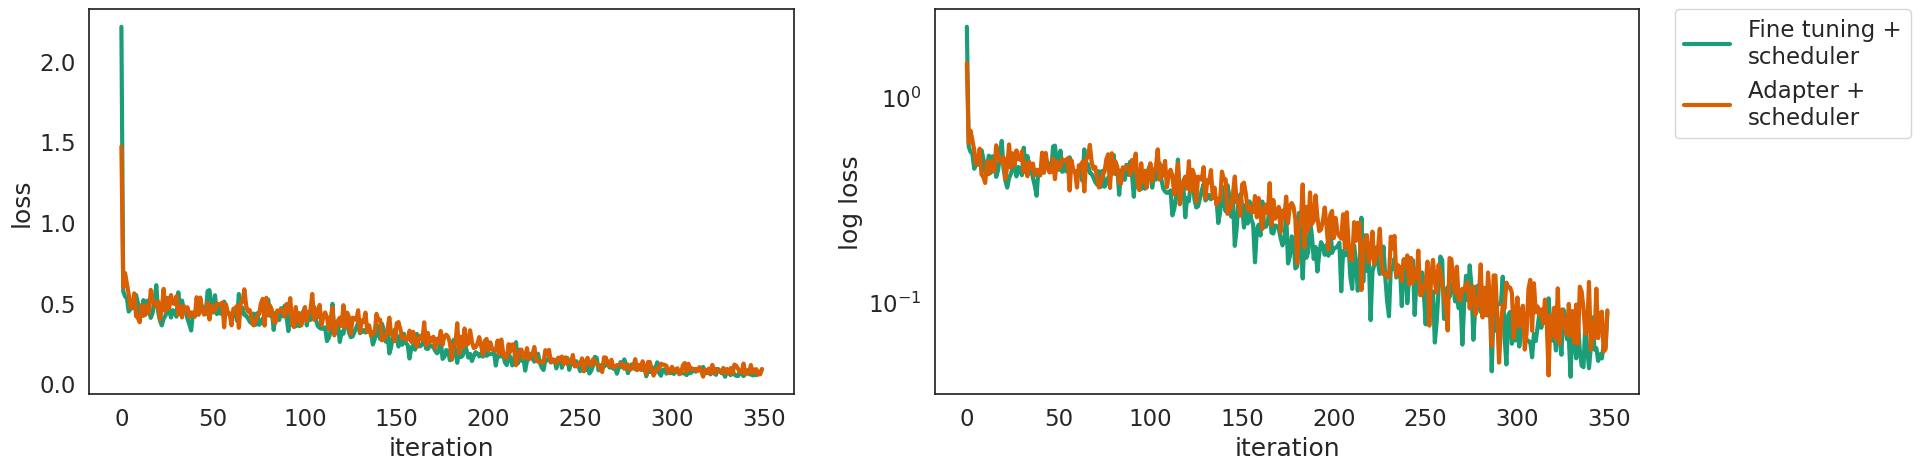

In [ ]:
#lossABTE = np.loadtxt('model_ABTE/losses_lr3.0000000000000004e-05_epochs9_batch8.txt')
lossABTE_AS = np.loadtxt('model_ABTE_adapter_scheduler/losses_lr3.0000000000000004e-05_epochs10_batch8.txt')
lossABTE_S = np.loadtxt('model_ABTE_scheduler/losses_lr3.0000000000000004e-05_epochs10_batch8.txt')
#lossABTE_A = np.loadtxt('model_ABTE_adapter/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')

sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5, palette="Dark2")
fig, ax = plt.subplots(1,2,figsize=(20,5))

for i in [0,1]:
    #sns.lineplot(range(len(lossABTE)), lossABTE, ax=ax[i], label = 'Fine tuning')
    sns.lineplot(data=(lossABTE_S), ax=ax[i], label = 'Fine tuning +\nscheduler')
    #sns.lineplot(range(len(lossABTE_A)), lossABTE_A, ax=ax[i], label = 'Adapter')
    sns.lineplot(data=(lossABTE_AS), ax=ax[i], label = 'Adapter +\nscheduler')

    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('loss')
ax[1].set_yscale('log')
ax[1].set_ylabel('log loss')
ax[0].legend().set_visible(False)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

if not os.path.isdir('results_ABTE'):
    os.makedirs('results_ABTE')
fig.savefig('results_ABTE/loss_lr{:.5f}_epochs{}_batch{}.pdf'.format(lr, epochs, batch), dpi=300, bbox_inches='tight')


In [ ]:
model_path = 'model_ABTE_scheduler'+'/model_lr3.0000000000000004e-05_epochs9_batch8.pkl'
kk = modelABTE.predict(aspects_raw.iloc[12, 4], load_model=model_path, device=DEVICE)

In [ ]:
def predictor(raw, model_path, model, idx, out_path):
    out = [[None, None, None, None, 0, None, '']]
    ids_to_cats = {1:'Food', 2:'Interior', 3:'Price', 4:'Service', 5:'Whole'}
    for i in range(raw.shape[0]):
        starts, ends, cats, _, text = raw.iloc[i,:]
        pairs = list(twt().span_tokenize(text))
        tokens, labels, _ = model.predict(text, load_model=model_path, device=DEVICE)
        assert len(pairs) == len(tokens)
        for t_id in range(len(tokens)):
            if labels[t_id] != 0:
                #line = {'review_id':idx[i], 'category':ids_to_cats[labels[t_id]],
                #        'span':pairs[t_id][1]-pairs[t_id][0],
                #        'span_start':pairs[t_id][0], 'span_end':pairs[t_id][1], 'sentiment':None}


                #так как берт отмечал отдельные токены а не н-граммы, надо соединить последовательности в н_граммы, где они есть
                if ((out[-1][4] + 1) == pairs[t_id][0]) and (out[-1][1] == ids_to_cats[labels[t_id]]):
                    #приклеиваем новый токен к старому
                    line_update = [out[-1][0], out[-1][1], out[-1][2]+pairs[t_id][1]-pairs[t_id][0],
                                   out[-1][3], pairs[t_id][1], None, out[-1][-1]+tokens[t_id]]
                    out.pop()
                    out.append(line_update)
                else:
                    line = [idx[i], ids_to_cats[labels[t_id]], pairs[t_id][1]-pairs[t_id][0],
                            pairs[t_id][0], pairs[t_id][1], None, tokens[t_id]]

                    out.append(line)
    out = ['\t'.join(list(map(lambda x: str(x), tt))) for tt in out]
    with open(out_path, 'w') as f:
      f.write('\n'.join(out[1:]))

In [ ]:
model_path = 'model_ABTE_scheduler'+'/model_lr3.0000000000000004e-05_epochs9_batch8.pkl'
predictor(devs_raw, model_path, dev_ids, 'fine-tuning_preds.txt')

In [ ]:
model_path = 'model_ABTE_adapter_scheduler'+'/model_lr3.0000000000000004e-05_epochs9_batch8.pkl'
predictor(devs_raw, model_path, dev_ids, 'adapter_preds.txt')